# Text classification using TfidVectorization and Multinomial Gaussian Naive Bayes
Using `imdb_labelled.text` dataset

# Import and inspect data

In [1]:
import numpy
import pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pandas.read_csv("./sentiment labelled sentences/imdb_labelled.txt",
                      sep = "\t",
                      header = None)

## Check null composition

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
0    748 non-null object
1    748 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


In [4]:
data.head()

,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


## Check Class balance

In [5]:
data[1].value_counts()

1    386
0    362
Name: 1, dtype: int64

In [6]:
# The classes appear to be quite well balanced

## Add headers

In [7]:
data.columns = ["comment_text", "sentiment_score"]
data.head()

,comment_text,sentiment_score
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


## Apply labels

In [8]:
def label(score):
    if score == 0:
        return 'Negative comment'
    else:
        return 'Positive comment'

In [9]:
data['label_class'] = data['sentiment_score'].apply(label) 
data.head()

,comment_text,sentiment_score,label_class
0,"A very, very, very slow-moving, aimless movie ...",0,Negative comment
1,Not sure who was more lost - the flat characte...,0,Negative comment
2,Attempting artiness with black & white and cle...,0,Negative comment
3,Very little music or anything to speak of.,0,Negative comment
4,The best scene in the movie was when Gerardo i...,1,Positive comment


# Build Model

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Create feature matrix and target vector

In [11]:
X = numpy.array(data["comment_text"])
y = numpy.array(data["sentiment_score"])

# Train test split (20/80 split)

In [12]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y,
                                                test_size = 0.20,
                                                random_state = 0)

# Create pipeline 
Pipeline will include
- Count vectorizer
- Term frequency inverse document frequency transformer
- Grid Search CV

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

In [14]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

text_clf = text_clf.fit(Xtrain, ytrain)

In [15]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 
              'tfidf__use_idf': (True, False), 
              'clf__alpha': (.01, .005, .001, .0001, .00001, .1, .5, .05)}

# Fit the model using parameters found in `GridSearchCV`

In [16]:
grid_clf = GridSearchCV(text_clf, parameters, n_jobs = -1)
grid_clf = grid_clf.fit(Xtrain, ytrain)

In [17]:
grid_clf.best_params_

{'clf__alpha': 0.1, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

# Make predictions using new model against test data (`Xtest`)

In [18]:
y_prediction = text_clf.predict(Xtest)

# Validate accuracy against `ytest`

In [19]:
accuracy = accuracy_score(y_prediction, ytest)

In [20]:
print('{:.2%}'.format(accuracy))

81.33%


# Cross Validate Model
Check if model generalizes well. Perform 10 fold cross validation on model

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
scoring = "accuracy"
kfold = 10
results = cross_val_score(grid_clf, Xtrain, ytrain, cv= kfold, scoring = scoring)
print(results)

[0.68333333 0.71666667 0.75       0.8        0.78333333 0.76666667
 0.73333333 0.7        0.86440678 0.76271186]


In [23]:
import seaborn
import matplotlib.pyplot as plt
seaborn.set_style = "whitegrid"
seaborn.set(rc = {"figure.figsize":(14,8)},
           font_scale = 1.6)

# Generate confusion matrix
Check how model performed by visualizing true vs predicted labels

Text(0.5, 1.0, 'Confusion Matrix\n Predicted vs True counts')

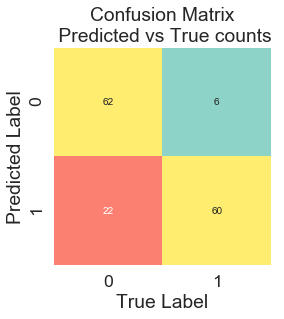

In [24]:
from sklearn.metrics import confusion_matrix


confusion_matrix = confusion_matrix(ytest, y_prediction)

seaborn.heatmap(confusion_matrix.T, 
               square  = True,
               annot = True,
               fmt = "d",
               cbar = False,
               cmap = "Set3")

plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix\n Predicted vs True counts")

# Calculate ROC

In [25]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import seaborn
from matplotlib import pyplot as plt

In [26]:
target_prob = text_clf.predict_proba(Xtest)[:,1]
fpr, tpr, thresh = roc_curve(ytest, target_prob)
auc_score = roc_auc_score(ytest, target_prob)

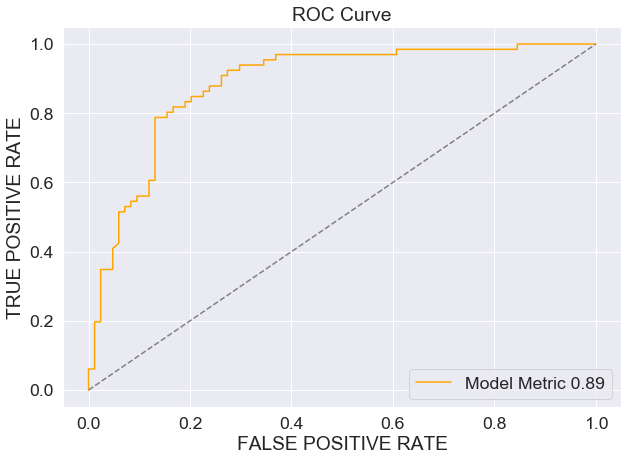

In [27]:
plt.figure(figsize=(10, 7))
plt.title('ROC Curve')
plt.plot(fpr, tpr, color='orange', label='Model Metric {:.2}'.format(auc_score))
plt.plot([0, 1], ls='--', color='grey')
plt.ylabel('TRUE POSITIVE RATE')
plt.xlabel('FALSE POSITIVE RATE')
plt.legend()
plt.show()

# Classification Report 

In [28]:
print(classification_report(ytest, y_prediction))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82        84
           1       0.73      0.91      0.81        66

   micro avg       0.81      0.81      0.81       150
   macro avg       0.82      0.82      0.81       150
weighted avg       0.83      0.81      0.81       150

